The _ibs.ipynb uses the standard IBS strategy on the daily timeframe.
This is the same, except enters and exits 1 minute before the close.

The performance is somewhat worse, but not significant. However this is much more realistic, as you cannot wait for the close and then enter.

{'Annual return %': 15.1, 'Sharpe': 1.09, 'Sortina': 1.14, 'Winning months %': 67.0, 'Time in market %': 36.0, 'Average profit %': 0.43, 'Average duration per trade': '3d17h46m', 'Profit factor': 0.8, 'Trades/month': 2.0, 'Annual expense ratio %': 7.4}


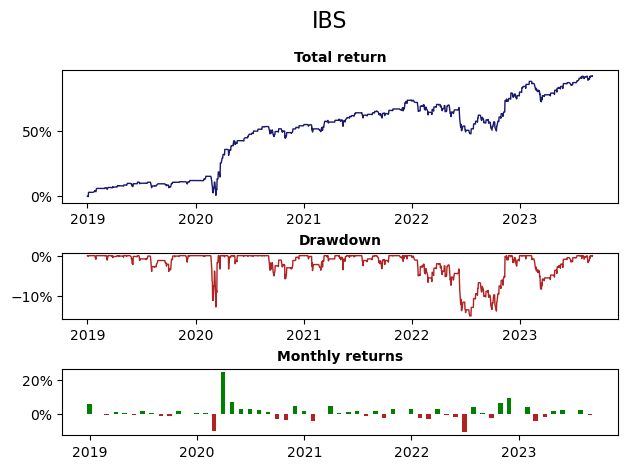

In [2]:
from backtester.event import OrderEvent
from backtester.strategy import Strategy
from backtester.backtest import Backtest
from backtester.data_handler import HistoricalPolygonDataHandler
from backtester.broker import SimulatedBroker
from backtester.portfolio import StandardPortfolio

from datetime import datetime, date, timedelta, time

class InternalBarStrengthStrategy(Strategy):
    def __init__(self, events, data_handler, portfolio, symbol="SPY"):
        self.events = events
        self.data_handler = data_handler  # To retrieve the data
        self.portfolio = portfolio  # To retrieve portfolio stats (equity, cash)

        self.data_handler.load_data(
            symbol,
            start_date=date(2019, 1, 1),
            end_date=date(2023, 9, 1),
            timeframe=1,
            extended_hours=False,
        )

        self.in_market = False

    def calculate_signals(self):
        current_market_close = self.data_handler.get_current_market_close_time()
        if self.data_handler.current_time ==  current_market_close - timedelta(minutes=1):
            # Calculate IBS. For this you need the 'daily' timeframe.
            bars_today = self.data_handler.get_latest_bars("SPY", N=390) # 390 = amount of minutes since market open
            bars_today_since_open = bars_today[bars_today.index.time >= time(9, 30)] # dealing with early closes
            
            high = bars_today_since_open['high'].max()
            low = bars_today_since_open['low'].min()
            close = bars_today_since_open.iloc[-1]['open']
            # print(self.data_handler.current_time)
            # print(high, low, close)

            ibs = (close - low) / (high - low)
            current_cash = self.portfolio.current_cash

            if not self.in_market and ibs <= 0.2:
                stocks_to_buy = int(current_cash / close)
                self.events.put(OrderEvent(self.data_handler.current_time, "SPY", "BUY", stocks_to_buy))
                self.in_market = True

            elif self.in_market and ibs >= 0.8:
                stocks_to_sell = self.portfolio.current_positions["SPY"]
                self.events.put(OrderEvent(self.data_handler.current_time, "SPY", "SELL", stocks_to_sell))
                self.in_market = False

    def on_backtest_end(self):
        # Liquidate everything
        for symbol, position in self.portfolio.current_positions.items():
            if position != 0:
                action = "SELL" if position > 0 else "BUY"
                order = OrderEvent(self.data_handler.current_time, symbol, action, position)
                self.events.put(order)

    def on_market_close(self):
        pass


backtest = Backtest(
    name="IBS_intraday",
    initial_capital=10000,
    start_date=date(2019, 1, 1),
    end_date=date(2023, 9, 1),
    timeframe=1,
    extended_hours=False,
    strategy=InternalBarStrengthStrategy,
    data_handler=HistoricalPolygonDataHandler,
    broker=SimulatedBroker,
    portfolio=StandardPortfolio,
)

backtest.run()